In [47]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
import lightgbm as lgb
sys.path.insert(0, 'C:/Users/vitil/OneDrive/Desktop/btc_project')

In [48]:
source_file = 'autoreg.csv'
df = pd.read_csv(f"C:/Users/vitil/OneDrive/Desktop/btc_project/data/{source_file}")
df= df.dropna()
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12307 entries, 3 to 12309
Columns: 2394 entries, ds to target_max_w720_lag1
dtypes: datetime64[ns](1), float64(2393)
memory usage: 224.9 MB


In [49]:
df = df.tail(10000)

In [50]:
df.head(10)

,ds,weights,y_mean_ratio_3_6_lag1,y_mean_ratio_3_12_lag1,y_mean_ratio_3_24_lag1,y_mean_ratio_3_48_lag1,y_mean_ratio_3_120_lag1,y_mean_ratio_3_168_lag1,y_mean_ratio_3_336_lag1,y_mean_ratio_6_12_lag1,...,target_std_w720_lag1,target_skew_w720_lag1,target_kurt_w720_lag1,target_min_w720_lag1,target_q10_w720_lag1,target_q25_w720_lag1,target_q50_w720_lag1,target_q75_w720_lag1,target_q90_w720_lag1,target_max_w720_lag1
2310,2024-05-16 09:00:00,0.12493,1.002089,1.001844,1.014491,1.042133,1.059936,1.062753,1.060565,0.999756,...,388.039987,-0.349188,6.990149,-2264.685235,-335.637618,-94.827927,77.235839,224.826270,435.660635,2515.57848
2311,2024-05-16 10:00:00,0.12493,1.003156,1.003258,1.014162,1.042705,1.061334,1.064414,1.062304,1.000101,...,388.164985,-0.352754,6.979868,-2264.685235,-335.637618,-94.827927,77.680082,226.049222,435.660635,2515.57848
2312,2024-05-16 11:00:00,0.12493,1.002392,1.003328,1.012046,1.041329,1.060712,1.064015,1.062026,1.000933,...,387.087878,-0.353116,7.073066,-2264.685235,-330.699931,-94.232252,78.128623,226.049222,435.660635,2515.57848
2313,2024-05-16 12:00:00,0.12493,1.001612,1.003994,1.010503,1.040808,1.060991,1.064566,1.062727,1.002379,...,387.363087,-0.352578,7.048249,-2264.685235,-330.699931,-94.232252,78.128623,226.049222,438.386522,2515.57848
2314,2024-05-16 13:00:00,0.12493,0.999699,1.002302,1.007267,1.037452,1.058358,1.062219,1.060462,1.002604,...,387.465334,-0.351003,7.037129,-2264.685235,-330.699931,-94.827927,78.128623,226.049222,438.386522,2515.57848
2315,2024-05-16 14:00:00,0.12493,1.000028,1.002667,1.006676,1.036710,1.058445,1.062542,1.060908,1.002639,...,387.359504,-0.356740,7.051038,-2264.685235,-324.971156,-94.232252,78.424899,226.223618,438.386522,2515.57848
2316,2024-05-16 15:00:00,0.12493,0.997227,0.998494,1.001397,1.030717,1.052961,1.057296,1.055749,1.001271,...,386.781270,-0.353049,7.093865,-2264.685235,-324.971156,-94.232252,78.424899,226.223618,438.386522,2515.57848
2317,2024-05-16 16:00:00,0.12493,0.997631,0.997722,0.999734,1.028367,1.051289,1.055901,1.054395,1.000091,...,386.068304,-0.357079,7.161575,-2264.685235,-318.901770,-93.970996,78.736205,227.536858,438.386522,2515.57848
2318,2024-05-16 17:00:00,0.12493,0.994258,0.992628,0.993555,1.021029,1.044504,1.049307,1.047834,0.998360,...,385.973437,-0.355231,7.162822,-2264.685235,-324.971156,-94.232252,78.424899,226.223618,435.779645,2515.57848
2319,2024-05-16 18:00:00,0.12493,0.995002,0.990563,0.990536,1.016679,1.040757,1.045781,1.044328,0.995540,...,386.005316,-0.354926,7.159426,-2264.685235,-324.971156,-94.232252,78.424899,226.223618,435.779645,2515.57848


In [51]:
n_samples = len(df)
train_idx = int(0.8 * n_samples)
val_idx = int(0.9 * n_samples)

train_data = df.iloc[:train_idx]
val_data = df.iloc[train_idx:val_idx]
test_data = df.iloc[val_idx:]

max_weight = train_data['weights'].max()
train_data['weights'] = train_data['weights'] / max_weight

feature_cols = [col for col in df.columns if col not in ['ds', 'y', 'target', 'weights']]

X_train = train_data[feature_cols].values
y_train = train_data['target'].values

X_val = val_data[feature_cols].values
y_val = val_data['target'].values

X_test = test_data[feature_cols].values
y_test = test_data['target'].values

train_dataset = lgb.Dataset(
                            X_train, 
                            label=y_train, 
                            feature_name=feature_cols 
                            #weight= train_data['weights']
                            )
val_dataset = lgb.Dataset(
                            X_val, 
                            label=y_val, 
                            reference=train_dataset, 
                            feature_name=feature_cols 
                            #weight= val_data['weights']
                            )

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Train samples: 8000
Validation samples: 1000
Test samples: 1000


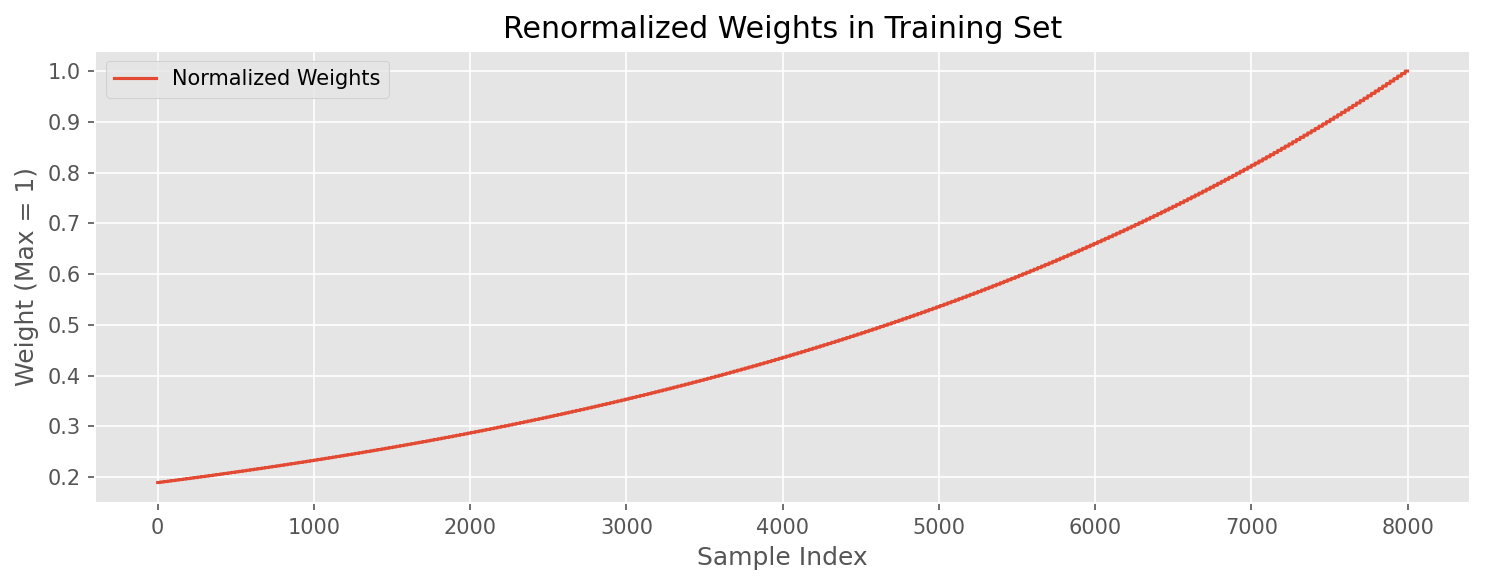

In [52]:
plt.figure(figsize=(10, 4))
plt.plot(train_data['weights'].values, label='Normalized Weights')
plt.title('Renormalized Weights in Training Set')
plt.xlabel('Sample Index')
plt.ylabel('Weight (Max = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
alpha=.5
k=2.5

def custom_objective(y_pred, dtrain):
    y_true = dtrain.get_label()
    z = y_true * y_pred
    sigmoid = 1 / (1 + np.exp(-k * z))

    grad = 2 * alpha * (y_pred - y_true) - (1 - alpha) * y_true * sigmoid
    hess = 2 * alpha + (1 - alpha) * k * y_true**2 * sigmoid * (1 - sigmoid)

    return grad, hess

In [54]:
params = {
    'objective': custom_objective, 
    'boosting_type': 'gbdt',
    'metric': 'None',  
    'num_leaves': 264, 
    'learning_rate': 0.006,
    'feature_fraction': 0.75,  
    'bagging_fraction': 1.0, 
    'min_data_in_leaf': 10,
    'num_threads': -1,
    'verbose': 1,
    'seed': 42
}

print("Training LightGBM model with custom loss...")
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000
)

Training LightGBM model with custom loss...
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 607991
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 2391
[LightGBM] [Info] Using self-defined objective function


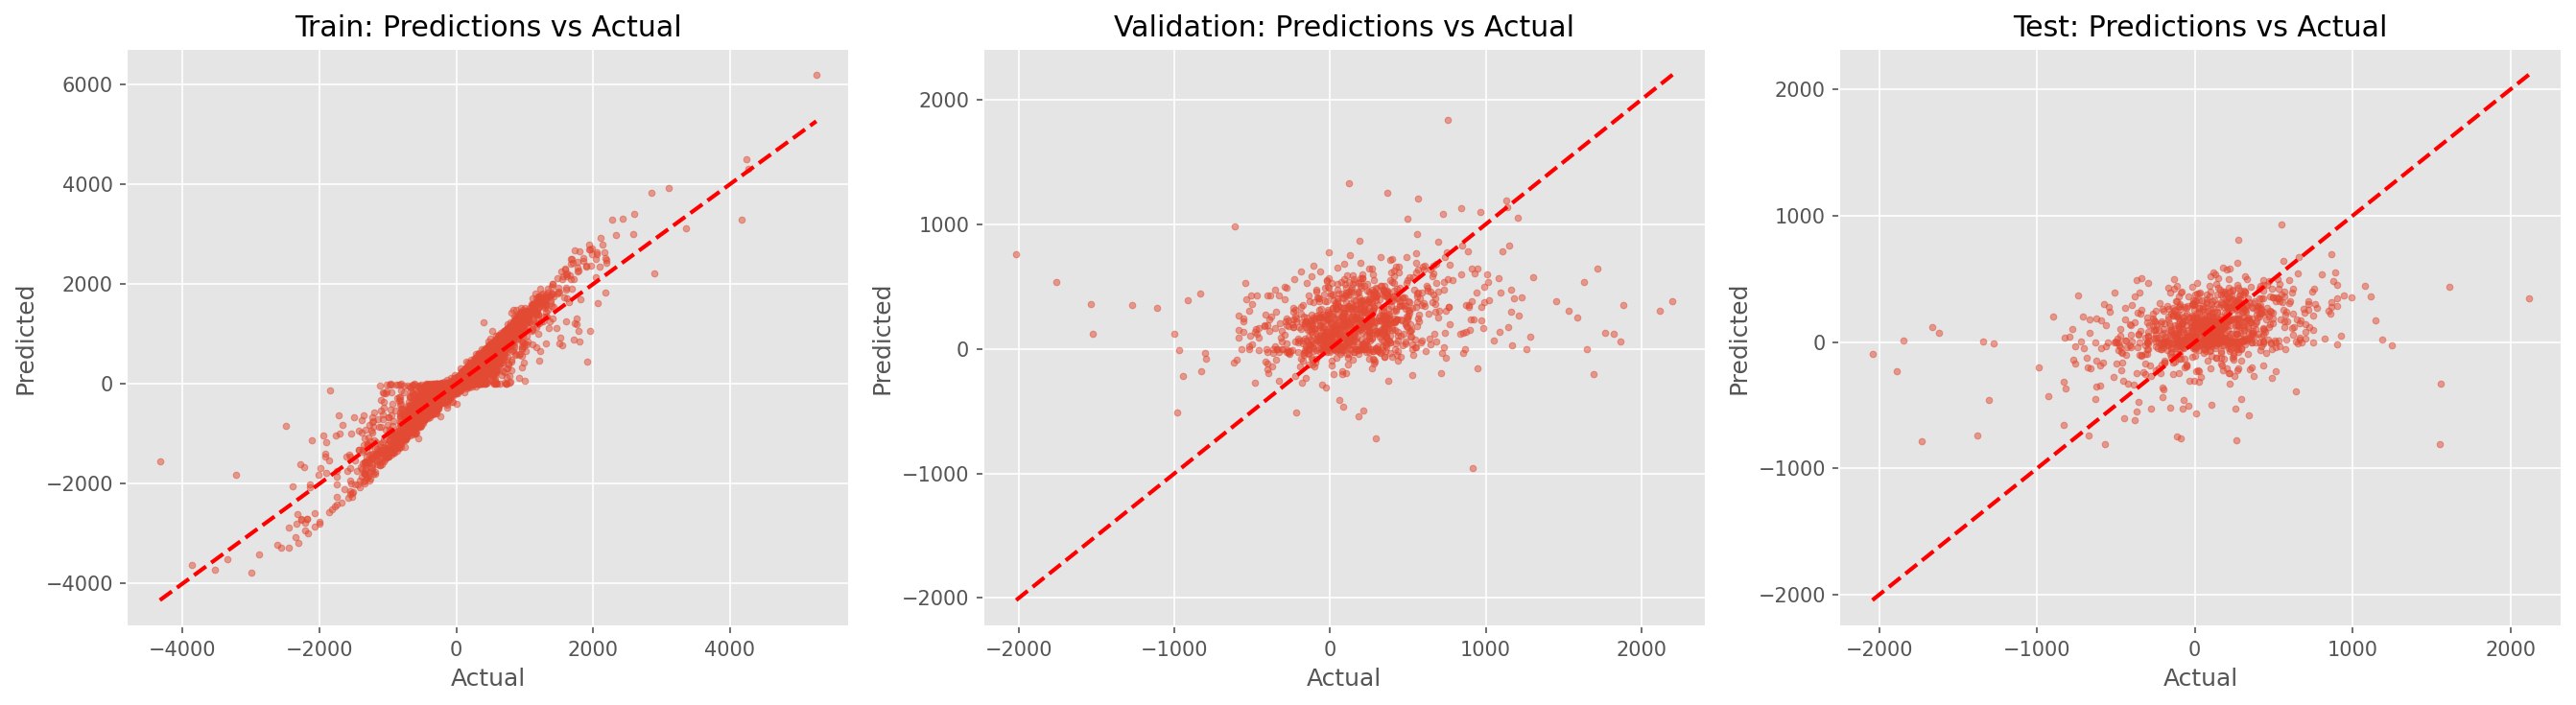


Model Performance Metrics:
                           Train  Validation        Test
Mean Absolute Loss    120.257483   292.50039  258.785884
Directional Accuracy    0.922625     0.71100    0.652000


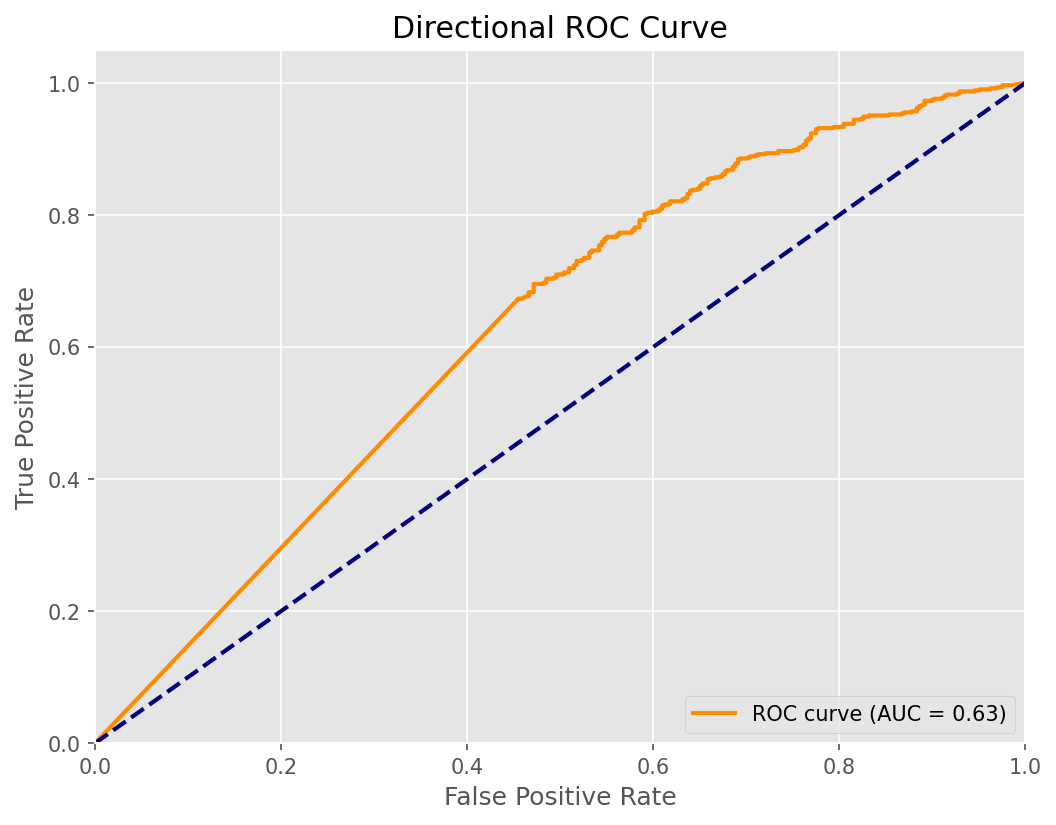

In [55]:
# Cell 8: Model evaluation
# Generate predictions
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# Create 3 subplots for predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train predictions
axes[0].scatter(y_train, train_pred, alpha=0.5, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Train: Predictions vs Actual')

# Validation predictions
axes[1].scatter(y_val, val_pred, alpha=0.5, s=10)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Validation: Predictions vs Actual')

# Test predictions
axes[2].scatter(y_test, test_pred, alpha=0.5, s=10)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')
axes[2].set_title('Test: Predictions vs Actual')

plt.tight_layout()
plt.show()

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    # Mean absolute loss
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Directional accuracy
    direction_correct = np.sum(np.sign(y_true) == np.sign(y_pred))
    directional_acc = direction_correct / len(y_true)
    
    return mae, directional_acc

# Generate metrics table
train_mae, train_dir_acc = calculate_metrics(y_train, train_pred)
val_mae, val_dir_acc = calculate_metrics(y_val, val_pred)
test_mae, test_dir_acc = calculate_metrics(y_test, test_pred)

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Train': [train_mae, train_dir_acc],
    'Validation': [val_mae, val_dir_acc],
    'Test': [test_mae, test_dir_acc]
}, index=['Mean Absolute Loss', 'Directional Accuracy'])

print("\nModel Performance Metrics:")
print(metrics_df)

# Plot directional ROC curve
from sklearn.metrics import roc_curve, auc

# Convert to binary classification problem (positive vs negative direction)
y_test_binary = (y_test > 0).astype(int)
y_pred_binary_proba = 1 / (1 + np.exp(-test_pred))  # Sigmoid transformation for probability

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_binary_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Directional ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

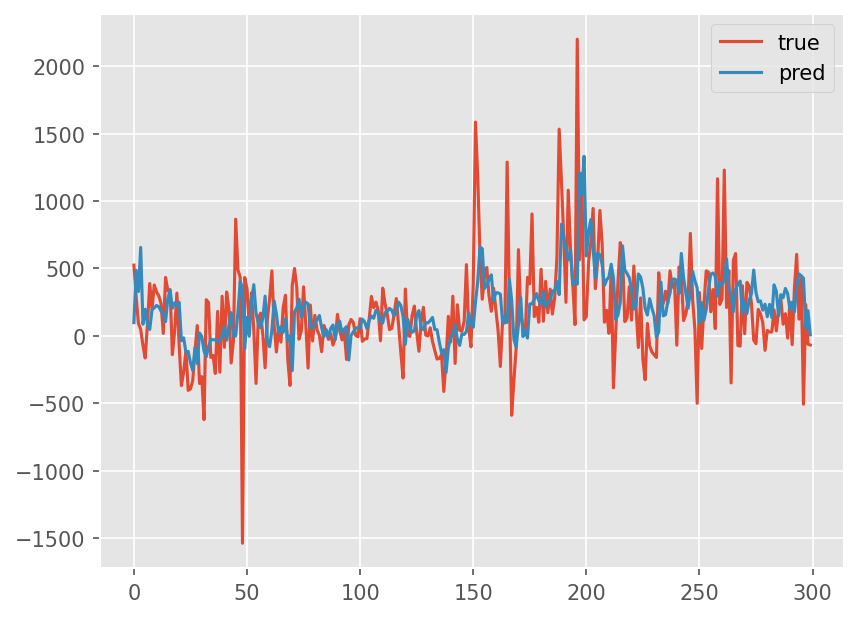

In [56]:
k=300
plt.plot(y_val[:k], label = 'true')
plt.plot(val_pred[:k],label = 'pred')
plt.legend()
plt.show()

In [57]:
from utils.fracdiff import get_weights

D_DEFAULT=0.75
THRESHOLD=0.0012